<a href="https://colab.research.google.com/github/Monish-Kumar-D/digit_recogniser/blob/main/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240525%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240525T142432Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D342e20fa3bb6e648c98c0ae9be218c2dcb99ad7f7de58a74872f9daa8a7536d969a8a780670cc602ae2d4a49e2cd998c00176a643e4f764e4a2b838aef00acb307a882a51de1f1cde8d8c9af3ace343b7fb8366b266ae0527bb681be25b33e77b843bd8aa6dfb4683b4e0027908738838a641436f8929468d76b906724282ebf320fb7ed9af9752d6c2755b3d4f074e80e79e4914a264d1efc01efec92556167e63cc5d56c9df44c28197eecc37036afbf395343a7fe2efb0a1c278d8d14f2b7fe97e8f29d91fceadc38d3b74bb8f4d4030dcb6ae1c60b52c25ffb15d6e1e2e7a0673a9692debd44655cc7c5cc3832bad2508bb2f81c30f52cd0424f6d191b5f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv


In [30]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [31]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

cross_validation_set = data[0:1000].T
Y_cv = cross_validation_set[0]
X_cv = cross_validation_set[1:n]
X_cv = X_cv / 255.
training_set = data[1000:m].T
X_train = training_set[1:n]
Y_train = training_set[0]
X_train = X_train/255.

In [33]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z,0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2


In [34]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X_val, Y_val, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_val)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X_val,  Y_val)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy : ",get_accuracy(get_predictions(A2),  Y_val))
    return W1, b1, W2, b2

In [35]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.8, 500)

Iteration:  0
[3 4 4 ... 4 8 9] [7 1 5 ... 9 5 1]
Accuracy :  0.10878048780487805
Iteration:  10
[1 1 8 ... 8 0 1] [7 1 5 ... 9 5 1]
Accuracy :  0.45014634146341465
Iteration:  20
[3 1 7 ... 9 0 1] [7 1 5 ... 9 5 1]
Accuracy :  0.6167073170731707
Iteration:  30
[3 1 8 ... 9 0 1] [7 1 5 ... 9 5 1]
Accuracy :  0.6895365853658536
Iteration:  40
[3 1 8 ... 4 5 1] [7 1 5 ... 9 5 1]
Accuracy :  0.6996829268292682
Iteration:  50
[8 1 8 ... 9 8 1] [7 1 5 ... 9 5 1]
Accuracy :  0.6768780487804879
Iteration:  60
[9 1 8 ... 9 5 1] [7 1 5 ... 9 5 1]
Accuracy :  0.7256829268292683
Iteration:  70
[7 1 8 ... 9 8 1] [7 1 5 ... 9 5 1]
Accuracy :  0.7846585365853659
Iteration:  80
[7 1 7 ... 9 8 1] [7 1 5 ... 9 5 1]
Accuracy :  0.7988048780487805
Iteration:  90
[7 1 9 ... 9 8 1] [7 1 5 ... 9 5 1]
Accuracy :  0.823560975609756
Iteration:  100
[7 1 9 ... 9 8 1] [7 1 5 ... 9 5 1]
Accuracy :  0.8299268292682926
Iteration:  110
[7 1 9 ... 9 8 1] [7 1 5 ... 9 5 1]
Accuracy :  0.8426585365853658
Iteration:  12

In [36]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [7]
Label:  7


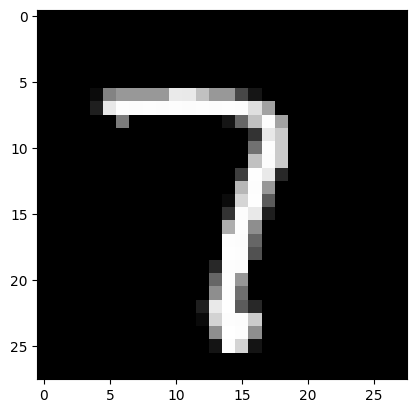

Prediction:  [1]
Label:  1


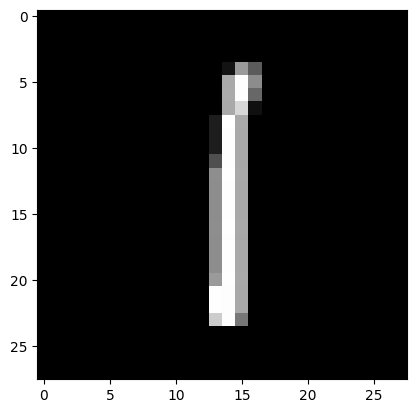

Prediction:  [7]
Label:  5


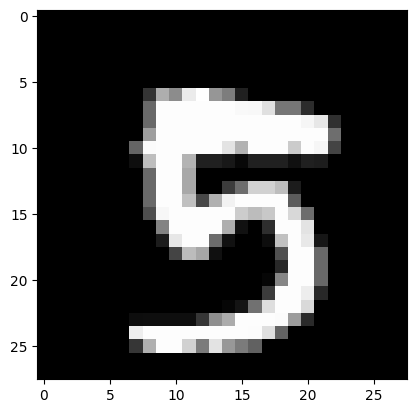

Prediction:  [3]
Label:  3


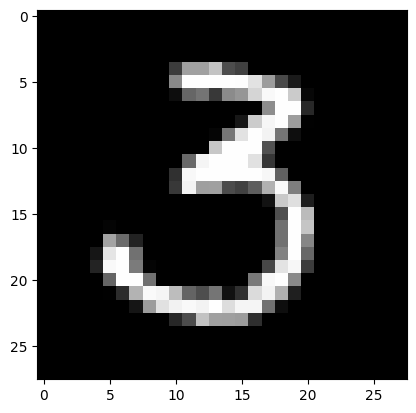

Prediction:  [8]
Label:  8


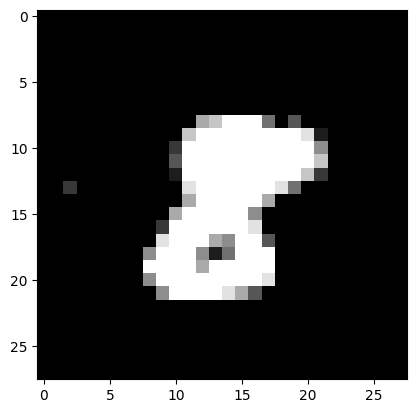

In [37]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(15,W1,b1,W2,b2)

In [38]:
crossvalidation_predictions = make_predictions(X_cv, W1, b1, W2, b2)
print("We get accuracy of: ",get_accuracy(crossvalidation_predictions, Y_cv)*100)

[4 7 8 0 5 3 6 1 9 4 6 3 4 5 6 5 5 5 4 4 0 0 9 0 4 4 9 3 3 5 0 5 9 1 7 1 0
 7 7 2 6 0 7 4 9 3 1 4 5 8 9 9 5 3 2 7 3 1 4 7 6 1 2 6 0 8 7 9 1 4 5 2 7 5
 3 5 5 0 1 5 0 1 1 6 4 9 8 4 2 8 5 2 4 2 7 7 2 5 7 0 8 6 1 5 4 0 3 3 4 7 6
 7 5 5 2 6 2 2 0 3 3 8 4 2 7 9 4 3 1 1 4 9 0 3 7 6 5 4 8 3 0 4 5 9 9 4 1 3
 8 7 9 1 1 3 6 3 4 7 6 7 9 8 6 2 4 2 0 6 6 1 3 7 8 8 3 4 9 1 3 8 5 4 3 1 1
 6 3 2 2 6 4 4 9 6 2 1 1 7 0 2 3 5 2 4 0 2 2 8 0 8 0 6 7 8 4 9 1 4 2 0 5 6
 2 2 0 5 0 1 8 0 5 7 1 2 0 9 7 4 3 0 1 9 6 2 3 2 8 9 2 7 4 9 2 1 5 7 1 4 1
 7 1 4 9 8 9 9 7 9 1 5 4 5 3 5 6 8 2 6 9 1 9 9 0 6 5 8 8 1 4 7 6 4 4 9 0 1
 5 1 9 4 3 8 6 6 9 2 6 6 5 8 8 9 2 4 1 4 7 0 0 0 8 7 1 3 3 2 3 5 6 1 8 2 4
 4 9 7 2 6 6 3 5 2 3 6 3 9 1 8 1 1 0 4 7 4 2 1 0 0 9 7 2 0 6 2 1 6 8 6 7 7
 8 1 6 5 3 6 1 4 3 0 1 1 7 1 3 2 2 6 8 0 7 0 4 1 5 6 2 3 7 6 8 7 9 3 0 1 1
 1 0 6 4 0 7 7 4 5 2 6 9 7 2 0 7 3 2 2 6 7 9 1 4 6 5 1 2 6 2 9 9 3 2 8 6 8
 1 4 3 5 4 6 7 9 8 8 9 4 3 7 0 9 0 8 1 4 1 8 2 6 3 4 6 4 4 4 7 2 4 5 1 7 6
 7 6 4 6 1 9 4 6 1 0 2 4 